## Demonstrate parameter estimation of GB signal
- Data: TDC II-0.1 verification dataset with VGBs. 
- Template: ``TDIFly`` waveform model 
- Methods: ``NESSAI`` nested sampler implemented in ``BILBY`` 

NOTE that this example doesn't require the installation of ``Triangle-GB``.

In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.TDI import *
from Triangle.GW import *
from Triangle.TDIFly import * 

import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'
import matplotlib.pyplot as plt

import multiprocessing
if __name__ == "__main__":
    multiprocessing.set_start_method("fork")

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


no cupy 


In [2]:
DATA_DIR = "/Users/taijidatacenter/workspace/TDCData/0_1_VGB_TDIXYZ.h5"
PARAM_DIR = "/Users/taijidatacenter/workspace/TDCData/0_1_VGB_parameters.h5"
ORBIT_DIR = "../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB"

## Load TDI data and true parameters

### Time-domain data and parameters 

In [3]:
with h5py.File(DATA_DIR, "r") as h5file: 
    data_dict = read_dict_from_h5(h5file["/"])

with h5py.File(PARAM_DIR, "r") as h5file: 
    inject_parameters = read_dict_from_h5(h5file["/"])

data_dict.keys(), inject_parameters.keys()

(dict_keys(['XYZ', 'time']),
 dict_keys(['A', 'f0', 'fdot0', 'inclination', 'latitude', 'longitude', 'phase0', 'psi']))

In [4]:
dt = data_dict["time"][1] - data_dict["time"][0]

# pad data to start from t=0
data_time_pad = np.arange(start=0., stop=data_dict["time"][0], step=dt)
data_time = np.concatenate((data_time_pad, data_dict["time"]))

Tobs = len(data_time) * dt 

A_data, E_data, _ = AETfromXYZ(data_dict["XYZ"]["X2"], data_dict["XYZ"]["Y2"], data_dict["XYZ"]["Z2"])
data_channels_td = np.zeros((2, len(data_time)))
data_channels_td[0][len(data_time_pad):] = A_data
data_channels_td[1][len(data_time_pad):] = E_data

channel_names = ["A", "E"]

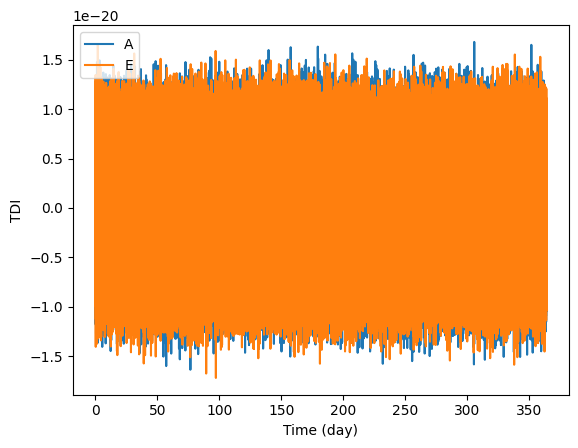

In [5]:
for i in range(len(data_channels_td)):
    plt.plot(data_time/DAY, data_channels_td[i], label=channel_names[i])
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper left")

### Fourier transform 

In [6]:
data_channels_fd = [] 
for i in range(len(data_channels_td)): 
    ff, xf = FFT_window(
        data_array=data_channels_td[i], 
        fsample=1./dt, 
        window_type="tukey", 
        window_args_dict=dict(alpha=10000/Tobs), 
    )
    data_channels_fd.append(xf)
data_frequency = ff 
data_channels_fd = np.array(data_channels_fd) 

(0.0001, 0.05)

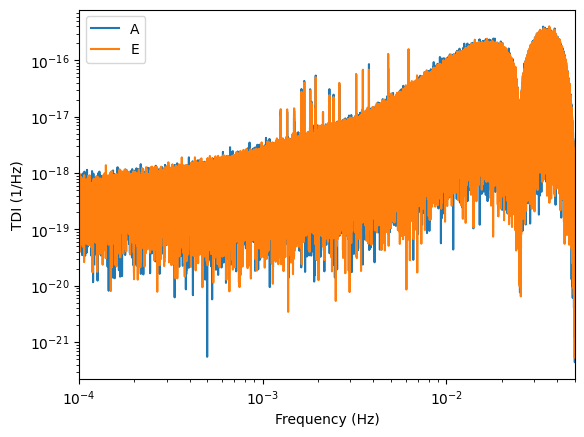

In [7]:
for i in range(len(data_channels_fd)):
    plt.loglog(data_frequency, np.abs(data_channels_fd[i]), label=channel_names[i]) 
plt.xlabel("Frequency (Hz)")
plt.ylabel("TDI (1/Hz)")
plt.legend(loc="upper left")
plt.xlim(1e-4, 0.05)

### select a freuqncy band to be analyzed 

In [8]:
# select a GB to analyze
analyze_gb_idx = 4

true_gb_parameters = {key: inject_parameters[key][analyze_gb_idx] for key in inject_parameters.keys()} 
true_gb_parameters

{'A': 9.517180373037876e-23,
 'f0': 0.0032247077104776,
 'fdot0': 5.536765590227253e-17,
 'inclination': 1.0471975511965976,
 'latitude': -0.3548927927646199,
 'longitude': 0.4294914200344345,
 'phase0': 1.3208186729980294,
 'psi': 2.099368941065471}

In [9]:
band_width = 5e-6

band_idx = np.where((data_frequency <= true_gb_parameters["f0"] + band_width/2)&(data_frequency >= true_gb_parameters["f0"] - band_width/2))[0]
data_frequency = data_frequency[band_idx]
data_channels_fd = data_channels_fd[:, band_idx] 

In [10]:
PSDlevel = np.mean(np.median(np.abs(data_channels_fd) ** 2 * 2. / Tobs, axis=1))

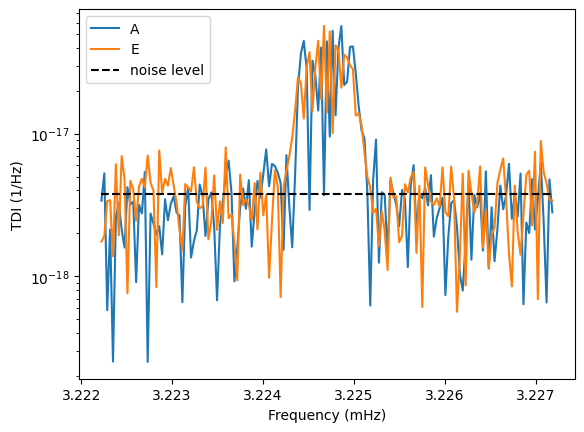

In [11]:
for i in range(len(data_channels_fd)):
    plt.semilogy(data_frequency*1e3, np.abs(data_channels_fd[i]), label=channel_names[i]) 
plt.hlines(np.sqrt(PSDlevel* Tobs / 2.), data_frequency[0]*1e3, data_frequency[-1]*1e3, colors="k", linestyles="--", label="noise level")
plt.xlabel("Frequency (mHz)")
plt.ylabel("TDI (1/Hz)")
plt.legend(loc="upper left")

## Waveform template model 

In [12]:
orbit = Orbit(OrbitDir=ORBIT_DIR)

X2_strings = TDIFly.X2_strings
Y2_strings = TDIStringManipulation.TDIStringCyc(X2_strings)
Z2_strings = TDIStringManipulation.TDIStringCyc(Y2_strings)

gb_tdifly_generator = TDIFlyGB(
    orbit=orbit, 
    Pstring_list=[X2_strings, Y2_strings, Z2_strings], 
    tcb_times=data_time.copy(), 
    Nsparse=512,
    use_gpu=False, 
)

## Likelihood and priors 

### Likelihood wrapper 
$${\rm ln}\mathcal{L}(\boldsymbol{\theta}) = -\frac{1}{2}\langle d - h(\boldsymbol{\theta}) | d - h(\boldsymbol{\theta}) \rangle$$

In [13]:
import bilby 

class bilby_likelihood_wrapper(bilby.Likelihood):
    def __init__(self):
        super().__init__(
            parameters={
                'A': None,
                'f0': None,
                'fdot0': None,
                'inclination': None,
                'latitude': None,
                'longitude': None,
                'phase0': None,
                'psi': None,
            }
        )

    def log_likelihood(self):
        return gb_tdifly_generator.Likelihood(
            data=data_channels_fd, 
            parameters=self.parameters, 
            StartBound=band_idx[0]+1, 
            EndBound=band_idx[-1]+1, 
            Tobs=Tobs, 
            S=PSDlevel, 
        )[0]

### Prior 
For the 4 "intrinsic" parameters, we use the same range as example 2.

In [14]:
priors = bilby.core.prior.PriorDict()
priors["A"] = bilby.prior.LogUniform(minimum=1e-23, maximum=1e-20, name='A', latex_label='$A$')
priors["f0"] = bilby.prior.Uniform(minimum=data_frequency[0], maximum=data_frequency[-1], name="f0", latex_label='$f_0$')
priors["fdot0"] = bilby.prior.Uniform(minimum=0, maximum=TDIFlyGB.fdot_upper_bound(data_frequency[0]), name="fdot0", latex_label='$\dot{f}_0$')
priors["inclination"] = bilby.prior.Sine(minimum=0., maximum=PI, name="inclination", latex_label='$\iota$')
priors["latitude"] = bilby.prior.Cosine(minimum=-PI/2., maximum=PI/2., name="latitude", latex_label='$\\beta$')
priors["longitude"] = bilby.prior.Uniform(minimum=0., maximum=TWOPI, name="longitude", latex_label='$\lambda$', boundary="periodic")
priors["phase0"] = bilby.prior.Uniform(minimum=0., maximum=TWOPI, name="phase0", latex_label='$\\varphi_0$', boundary="periodic")
priors["psi"] = bilby.prior.Uniform(minimum=0., maximum=PI, name="psi", latex_label='$\psi$', boundary="periodic")
priors

{'A': LogUniform(minimum=1e-23, maximum=1e-20, name='A', latex_label='$A$', unit=None, boundary=None),
 'f0': Uniform(minimum=0.003222223104847999, maximum=0.003227179931208147, name='f0', latex_label='$f_0$', unit=None, boundary=None),
 'fdot0': Uniform(minimum=0, maximum=7.298560749333524e-16, name='fdot0', latex_label='$\\dot{f}_0$', unit=None, boundary=None),
 'inclination': Sine(minimum=0.0, maximum=3.141592653589793, name='inclination', latex_label='$\\iota$', unit=None, boundary=None),
 'latitude': Cosine(minimum=-1.5707963267948966, maximum=1.5707963267948966, name='latitude', latex_label='$\\beta$', unit=None, boundary=None),
 'longitude': Uniform(minimum=0.0, maximum=6.283185307179586, name='longitude', latex_label='$\\lambda$', unit=None, boundary='periodic'),
 'phase0': Uniform(minimum=0.0, maximum=6.283185307179586, name='phase0', latex_label='$\\varphi_0$', unit=None, boundary='periodic'),
 'psi': Uniform(minimum=0.0, maximum=3.141592653589793, name='psi', latex_label='$\

## Parameter estimation 

In [15]:
BLike = bilby_likelihood_wrapper()

ncpu = multiprocessing.cpu_count()
print("number of cpus =", ncpu)

result = bilby.run_sampler(
    likelihood=BLike, 
    priors=priors,
    sampler="nessai", 
    # nlive=2000, # seems that nlive=500 is OK
    nlive=500,
    stopping=0.01, 
    npool=ncpu, # use all cpus 
    injection_parameters=true_gb_parameters, 
    outdir="./Samples",
    label="vgb_example",
    plot=True,
    resume=False, 
    # resume=True, 
)

00:15 bilby INFO    : Running for label 'vgb_example', output will be saved to './Samples'


number of cpus = 12


/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/bilby/core/utils/log.py:73: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  vdict[key] = str(getattr(sys.modules[key], "__version__", "N/A"))
00:15 bilby INFO    : Analysis priors:
00:15 bilby INFO    : A=LogUniform(minimum=1e-23, maximum=1e-20, name='A', latex_label='$A$', unit=None, boundary=None)
00:15 bilby INFO    : f0=Uniform(minimum=0.003222223104847999, maximum=0.003227179931208147, name='f0', latex_label='$f_0$', unit=None, boundary=None)
00:15 bilby INFO    : fdot0=Uniform(minimum=0, maximum=7.298560749333524e-16, name='fdot0', latex_label='$\\dot{f}_0$', unit=None, boundary=None)
00:15 bilby INFO    : inclination=Sine(minimum=0.0, maximum=3.141592653589793, name='inclination', latex_label='$\\iota$', unit=None, boundary=None)
00:15 bilby INFO    : latitude=Cosine(minimum=-1.57

01-19 00:15 nessai INFO    : Running Nessai version 0.14.0.post0
01-19 00:15 nessai INFO    : Starting multiprocessing pool with 12 processes


/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/nessai/utils/logging.py:133: FutureWarning: setup_logger is deprecated, use configure_logger instead
  warnings.warn(


01-19 00:15 nessai INFO    : Initialising nested sampler
01-19 00:15 nessai WARNING : Multiprocessing pool has already been configured.
01-19 00:15 nessai WARNING : Removing unused keyword arguments ({'n_accept', 'step_kwargs', 'generate_augment', 'max_n_clusters', 'plot_chain', 'marginalise_augment', 'n_steps', 'step_type', 'ensemble_fraction', 'n_marg', 'augment_dims', 'enforce_likelihood_threshold', 'plot_history'}) from kwargs for FlowProposal. These are valid keyword arguments but correspond to other proposal classes.
01-19 00:15 nessai INFO    : Passing kwargs to FlowProposal: {'training_config': None, 'poolsize': 1000, 'check_acceptance': False, 'max_poolsize_scale': 10, 'update_poolsize': True, 'accumulate_weights': False, 'save_training_data': False, 'reparameterisations': None, 'fallback_reparameterisation': 'zscore', 'use_default_reparameterisations': None, 'reverse_reparameterisations': False, 'map_to_unit_hypercube': False, 'latent_prior': 'truncated_gaussian', 'constant_v

00:20 bilby INFO    : Sampling time: 0:04:51.142773
00:20 bilby INFO    : Summary of results:
nsamples: 2494
ln_noise_evidence:    nan
ln_evidence: -350.294 +/-  0.266
ln_bayes_factor:    nan +/-  0.266



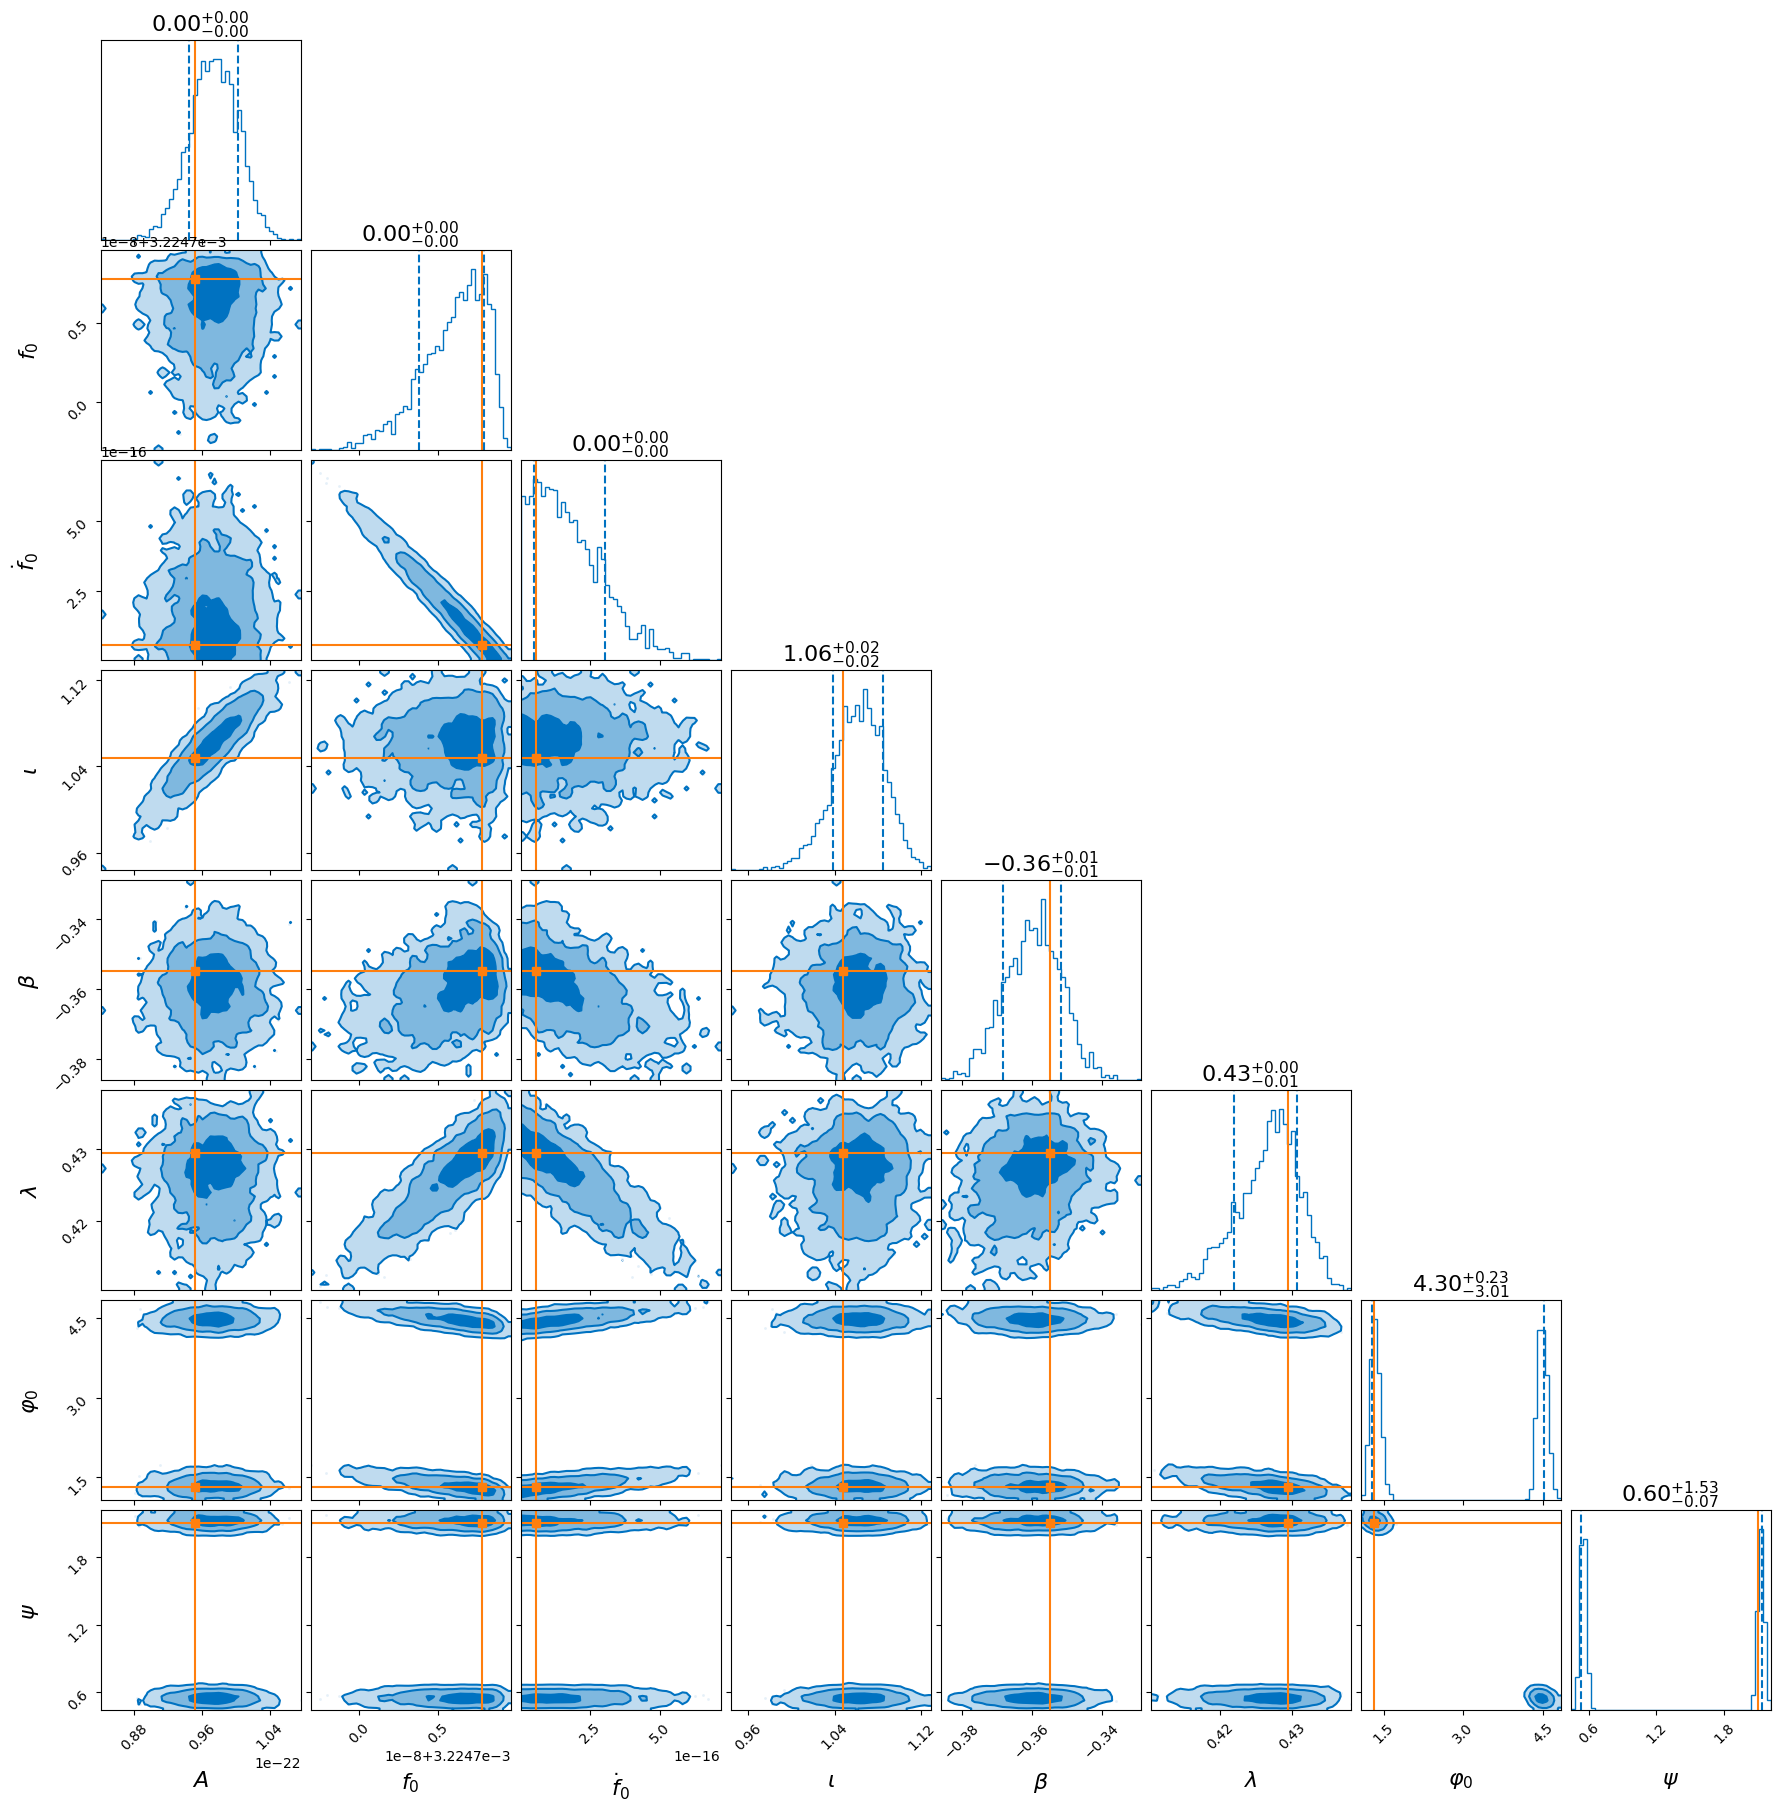

In [16]:
result.plot_corner(save=True)